In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn import tree
from sklearn.metrics import classification_report
from tester import test_classifier

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

In [3]:
features_list = ['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 #'email_address',
 'from_poi_to_this_person' ,
 'long_incentive_over_salary_ratio', # new created
 'bonus_over_salary_ratio']  # new created


In [4]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [5]:
### how many people are in the dataset
len(data_dict)

146

In [6]:
### for each person, how may features are available (include 'email_address' and 'poi', not include new created features)
len(data_dict['ALLEN PHILLIP K'])

21

In [7]:
#### how many "poi" in the dataset
poi_list =[]

for k in data_dict:
    if data_dict[k]["poi"] == True:
        poi_list.append(k)
        
print (poi_list, len(poi_list))

(['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H', 'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F'], 18)


In [8]:
### features with missing vales percentage

features = data_dict['ALLEN PHILLIP K'].keys()    # get all features
features_NaN = {}

for i in range(0, len(features)):    
    feature = features[i]      # get each feature name in every for loop
    m = 0      # count how many NaN for each feature               
    for k in data_dict:      # loop each person
        if data_dict[k][feature] == 'NaN':     # if the feature is NaN for the looped person
            m += 1       # count how many people have 'NaN' for this feature
    features_NaN[feature] = round(float(m) / float(len(data_dict)), 2)       # 2 decimal percentage of NaN for each feature

features_NaN

{'bonus': 0.44,
 'deferral_payments': 0.73,
 'deferred_income': 0.66,
 'director_fees': 0.88,
 'email_address': 0.24,
 'exercised_stock_options': 0.3,
 'expenses': 0.35,
 'from_messages': 0.41,
 'from_poi_to_this_person': 0.41,
 'from_this_person_to_poi': 0.41,
 'loan_advances': 0.97,
 'long_term_incentive': 0.55,
 'other': 0.36,
 'poi': 0.0,
 'restricted_stock': 0.25,
 'restricted_stock_deferred': 0.88,
 'salary': 0.35,
 'shared_receipt_with_poi': 0.41,
 'to_messages': 0.41,
 'total_payments': 0.14,
 'total_stock_value': 0.14}

In [9]:
### Task 2: Remove outliers

Because of the size of dataset, I tend to be conservative about outliers. The two outliers I decide to remove are "TOTAL" and "THE TRAVEL AGENCY IN THE PARK", which are mentioned in the "enron61702insiderpay.pdf".

In [10]:
data_dict.pop('TOTAL', 0 ) 
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0 ) 

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [11]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.


It seems that POI are a group of people who chase short term benefits. So I use "bonus" as short-term benefits and "long_term_incentive" as long-term benefits, and make both of them divides by "bonus" since bonus is a fair measure of position in a company.

In [12]:
for person in data_dict:  # create 'long_incentive_over_salary_ratio'
    if data_dict[person]['salary'] != "NaN" and data_dict[person]['long_term_incentive'] != 'NaN':
        data_dict[person]['long_incentive_over_salary_ratio'] = float(data_dict[person]['long_term_incentive'])\
          / float(data_dict[person]['salary'])
    else:
        data_dict[person]['long_incentive_over_salary_ratio'] = 0
        
for person in data_dict:   # create 'bonus_over_salary_ratio'  
    if data_dict[person]['salary'] != "NaN" and data_dict[person]['bonus'] != 'NaN':
        data_dict[person]['bonus_over_salary_ratio'] = float(data_dict[person]['bonus'])\
          / float(data_dict[person]['salary'])
    else:
        data_dict[person]['bonus_over_salary_ratio'] = 0

In [13]:
# transform data_dict to data frame

df = pd.DataFrame.from_dict(data_dict)
df = df.transpose()

df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

#reference https://discussions.udacity.com/t/enron-data-pandas/199298/2
 
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)  
df.fillna(0, inplace = True)

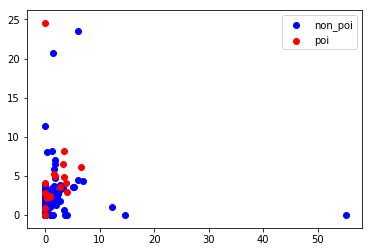

In [14]:
# plot new created features

plt.scatter(df[df['poi']==0]['long_incentive_over_salary_ratio'],df[df['poi']== 0]['bonus_over_salary_ratio'], c = 'b')
plt.scatter(df[df['poi']==1]['long_incentive_over_salary_ratio'],df[df['poi']== 1]['bonus_over_salary_ratio'], c = 'r')
plt.legend(("non_poi", "poi"))

From the graph, it seems that POIs are not likely having "long_incentive_over_salary_ratio" greater than 10. 

In [15]:
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [16]:
### Task 4: Try a varity of classifiers & Task 5: Tune parameters

In [17]:
#cross validation
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
sss = StratifiedShuffleSplit(labels_train, 1000, random_state = 42)

In [18]:
# first classifier: GaussianNB()


kbest = SelectKBest(f_classif)
classifier = GaussianNB()

steps = [('k_best', kbest),('classifier', classifier)]

pipeline = Pipeline(steps)

param_grid = {'k_best__k': range(3, 10)}

clf = GridSearchCV(pipeline, param_grid, scoring="f1",cv=sss)
    
clf.fit(features_train, labels_train)

print clf.best_params_

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'k_best__k': 9}


In [19]:
# predict and scores
pred = clf.predict(features_test)
recall = recall_score(labels_test, pred)
precision = precision_score(labels_test, pred)
accuracy = accuracy_score(labels_test, pred)
print recall, precision, accuracy

0.4 0.4 0.8604651162790697


In [20]:
# SelectKBest scores
KBest = clf.best_estimator_.named_steps['k_best']
KBest.scores_

array([1.58587309e+01, 2.61618300e+00, 9.98239959e-03, 8.95913665e+00,
       9.68004143e+00, 3.07287746e+01, 8.05830631e+00, 1.07225708e+01,
       7.27124110e-01, 1.06338520e+01, 4.18072148e+00, 7.03793280e+00,
       4.35374099e-01, 3.20445914e+00, 1.11208239e-01, 1.64109793e+00,
       8.79220385e+00, 7.55511978e+00, 4.95866668e+00, 2.76784090e-02,
       2.11171142e+01])

In [21]:
# second classifier: SVM


scaler = MinMaxScaler()
kbest = SelectKBest(f_classif)
classifier = svm.SVC()

steps = [('scaler', scaler), ('k_best', kbest), ('classifier', classifier)]
pipeline = Pipeline(steps)

param_grid = {'k_best__k': range(10,15), 'classifier__kernel': ['linear','rbf'],
             'classifier__C':[0.01,0.1,1,10,100,1000], 'classifier__gamma':[0.001,0.01,0.1,1,10,100]}

clf = GridSearchCV(pipeline, param_grid, scoring="f1",cv=sss)
    
clf.fit(features_train, labels_train)

print clf.best_params_

{'k_best__k': 14, 'classifier__gamma': 1, 'classifier__kernel': 'rbf', 'classifier__C': 1000}


In [22]:
pred = clf.predict(features_test)
recall = recall_score(labels_test, pred)
precision = precision_score(labels_test, pred)
accuracy = accuracy_score(labels_test, pred)
print recall, precision, accuracy

0.2 0.1111111111111111 0.7209302325581395


In [23]:
# third classifier: Decision Tree


kbest = SelectKBest(f_classif)
pca = PCA()
classifier = tree.DecisionTreeClassifier()


steps = [('k_best', kbest), ('pca', pca), ('classifier', classifier)]

pipeline = Pipeline(steps)


param_grid = {'k_best__k': range(10,15), 'pca__n_components': [2,3,4], 'classifier__min_samples_split': range(18,25), \
             'classifier__criterion': ['gini', 'entropy'], 'classifier__min_samples_leaf': [2,3,4,5], \
             'classifier__max_leaf_nodes': [None,2,3,4]}

clf = GridSearchCV(pipeline, param_grid, scoring="f1",cv=sss)
    
clf.fit(features_train, labels_train)

print clf.best_params_

{'classifier__min_samples_split': 23, 'pca__n_components': 3, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 3, 'k_best__k': 12, 'classifier__criterion': 'gini'}


In [24]:
pred = clf.predict(features_test)
recall = recall_score(labels_test, pred)
precision = precision_score(labels_test, pred)
accuracy = accuracy_score(labels_test, pred)
print recall, precision, accuracy

0.2 0.1 0.6976744186046512


In [25]:
### test if the new created feature "bonus_over_salary_ratio" is really useful to improve performance of algorithm

In [26]:
with_new_features_list = ["poi", "bonus", "bonus_over_salary_ratio", "salary", "shared_receipt_with_poi", "total_stock_value", \
                      "exercised_stock_options", "total_payments", "deferred_income", "restricted_stock"]

without_new_feature_list = ["poi", "bonus", "salary", "shared_receipt_with_poi", "total_stock_value", \
                      "exercised_stock_options", "total_payments", "deferred_income", "restricted_stock"]

In [27]:
clf = GaussianNB()

In [28]:
# performance scores when have new created feature "bonus_over_salary_ratio" 
test_classifier(clf, my_dataset, with_new_features_list)

GaussianNB(priors=None)
	Accuracy: 0.84420	Precision: 0.39409	Recall: 0.31350	F1: 0.34921	F2: 0.32687
	Total predictions: 15000	True positives:  627	False positives:  964	False negatives: 1373	True negatives: 12036



In [29]:
# performance scores when DOES NOT have new created feature "bonus_over_salary_ratio" 
test_classifier(clf, my_dataset, without_new_feature_list)

GaussianNB(priors=None)
	Accuracy: 0.84420	Precision: 0.39409	Recall: 0.31350	F1: 0.34921	F2: 0.32687
	Total predictions: 15000	True positives:  627	False positives:  964	False negatives: 1373	True negatives: 12036



Comparing the two test results, we found that the new created feature "bonus_over_salary_ratio" isn't helpful to improve algorithm performance. So we will delete it from the final featue list .

In [30]:
# Final analysis

In [31]:
#feature_list for final analysis
final_feature_list = ["poi", "bonus", "salary", "shared_receipt_with_poi", "total_stock_value", \
                      "exercised_stock_options", "total_payments", "deferred_income", "restricted_stock"]

In [32]:
#extract and validate data
data = featureFormat(my_dataset, final_feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
sss = StratifiedShuffleSplit(labels,  1000, random_state = 42)

In [33]:
# final algorithm
clf = GaussianNB()
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

# performance score in sklearn metrics
recall = recall_score(labels_test, pred)
precision = precision_score(labels_test, pred)

In [34]:
# test classifier in tester.py
test_classifier(clf, my_dataset, final_feature_list)

GaussianNB(priors=None)
	Accuracy: 0.84420	Precision: 0.39409	Recall: 0.31350	F1: 0.34921	F2: 0.32687
	Total predictions: 15000	True positives:  627	False positives:  964	False negatives: 1373	True negatives: 12036



In [35]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, final_feature_list)